In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, multivariate_normal

import pymc3 as pm
import arviz as az

### Water example

In [2]:
n = 9
x = 6

In [3]:
with pm.Model() as normal_approximation:
    theta = pm.Uniform('theta', 0, 1)
    water = pm.Binomial('water', n=n, p=theta, observed=x)
    mean_q = pm.find_MAP()
    IFisher = pm.find_hessian(mean_q, vars=[theta])
    std_q = (1/IFisher**0.5)[0]

mean_q['theta'], std_q

(array(0.66666667), array([0.15713484]))

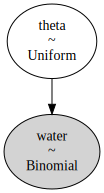

In [4]:
pm.model_to_graphviz(normal_approximation)

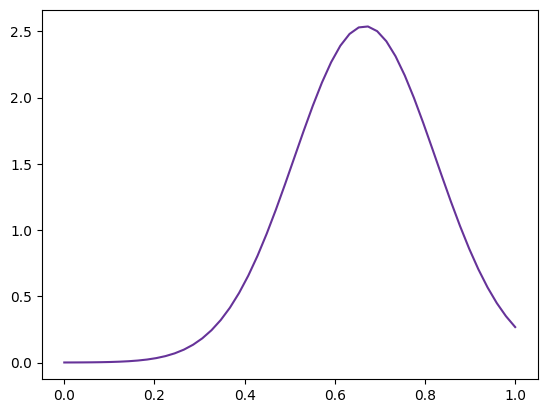

In [5]:
theta_grid = np.linspace(0,1)
posterior_quadratic_approx = norm.pdf(theta_grid, mean_q['theta'], std_q)
plt.plot(theta_grid, posterior_quadratic_approx, color='rebeccapurple')

### Height example

In [6]:
dat = pd.read_csv('Howell1.csv', sep=';')

# We are interested in adult's height
dat_adults = dat[dat['age'] >= 18]

In [7]:
with pm.Model() as normal_approximation:
    mu      = pm.Normal('mu', mu=170, sd=10)
    sigma   = pm.Uniform('sigma', lower=0, upper=33)
    height  = pm.Normal('height', mu=mu, sd=sigma, observed=dat_adults['height'])
    mean_q  = pm.find_MAP()
    IFisher = pm.find_hessian(mean_q, vars=[mu, sigma])

IFisher_inverse = np.linalg.inv(IFisher)

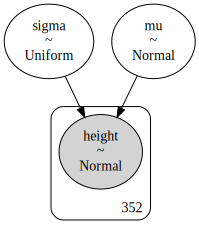

In [8]:
pm.model_to_graphviz(normal_approximation)

In [9]:
posterior_sample = multivariate_normal.rvs(
    size=10**3,
    mean=np.array([mean_q['mu'], mean_q['sigma']]),
    cov=IFisher_inverse
    )

posterior_sample = pd.DataFrame(posterior_sample, columns=['mu', 'sigma'])

/home/dmitri/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, '$\\sigma$')

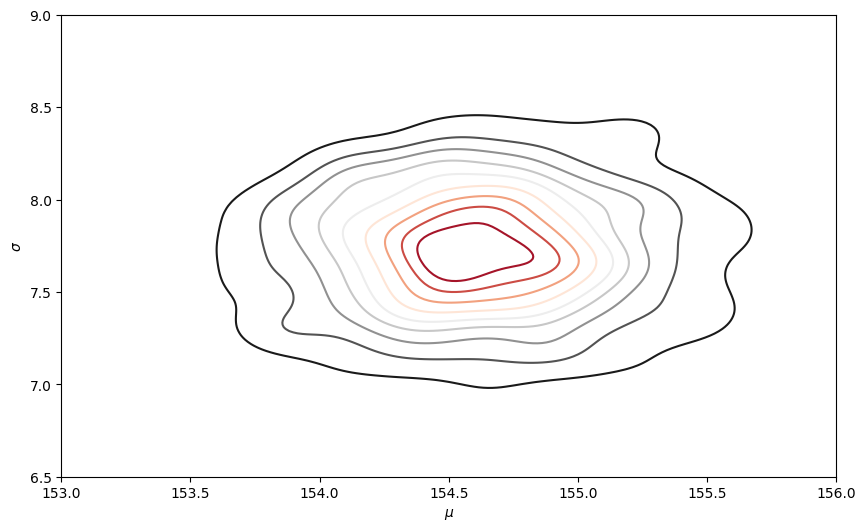

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(posterior_sample['mu'], posterior_sample['sigma'], 
            cmap=plt.cm.RdGy_r, ax=ax, n_levels=10)
ax.set_xlim(153, 156)
ax.set_ylim(6.5, 9)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\sigma$')

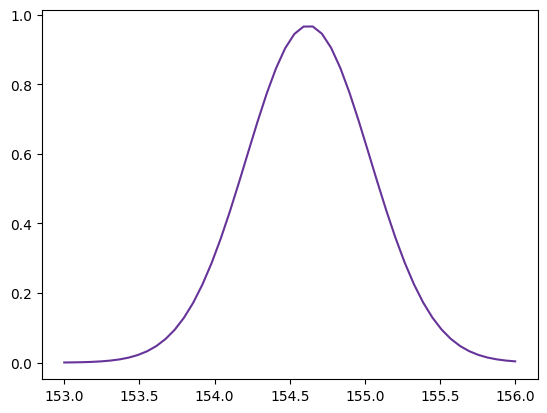

In [11]:
mu_grid = np.linspace(153,156)
posterior_quadratic_approx = norm.pdf(mu_grid, mean_q['mu'], IFisher_inverse[0][0]**0.5)
plt.plot(mu_grid, posterior_quadratic_approx, color='rebeccapurple')

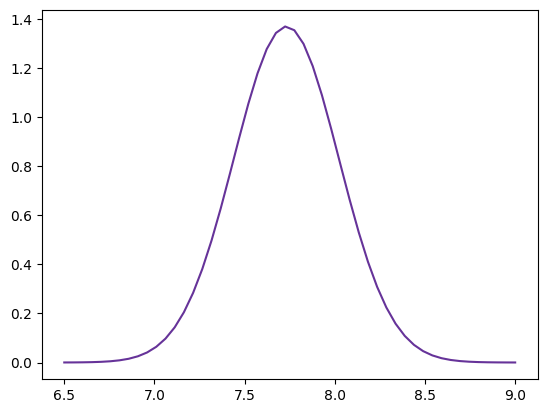

In [12]:
sigma_grid = np.linspace(6.5,9)
posterior_quadratic_approx = norm.pdf(sigma_grid, mean_q['sigma'], IFisher_inverse[1][1]**0.5)
plt.plot(sigma_grid, posterior_quadratic_approx, color='rebeccapurple')

### Regression for adults' weights

In [13]:
with pm.Model() as normal_approximation:
    alpha    = pm.Normal('alpha', mu=170, sd=10)
    beta     = pm.Lognormal('beta', mu=0, sigma=1)
    sigma    = pm.Uniform('sigma', lower=0, upper=33)
    height   = pm.Normal('height',
                         mu=alpha + beta*(dat_adults['weight']-dat_adults['weight'].mean()),
                         sd=sigma, observed=dat_adults['height'])
    mean_q = pm.find_MAP()
    IFisher  = pm.find_hessian(mean_q, vars=[alpha, beta, sigma])

IFisher_inverse = np.linalg.inv(IFisher)

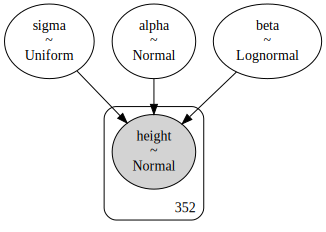

In [14]:
pm.model_to_graphviz(normal_approximation)

In [15]:
IFisher_inverse.round(3)

array([[ 0.073, -0.   ,  0.   ],
       [-0.   ,  0.002, -0.   ],
       [ 0.   , -0.   ,  0.037]])

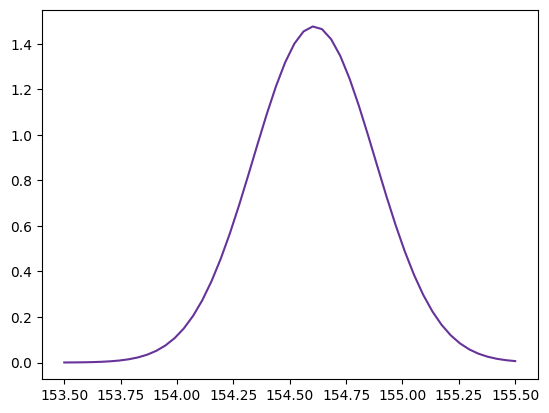

In [16]:
alpha_grid = np.linspace(153.5,155.5)
posterior_quadratic_approx = norm.pdf(alpha_grid, mean_q['alpha'], IFisher_inverse[0][0]**0.5)
plt.plot(alpha_grid, posterior_quadratic_approx, color='rebeccapurple')

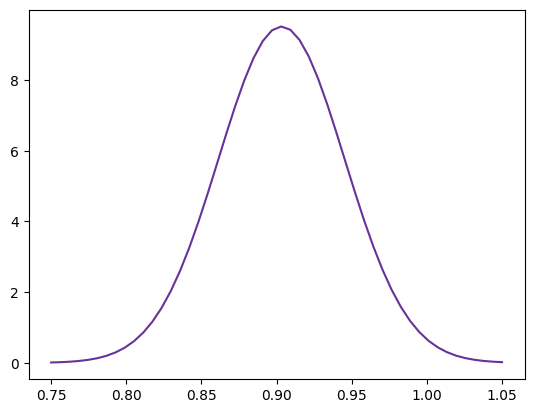

In [17]:
beta_grid = np.linspace(0.75, 1.05)
posterior_quadratic_approx = norm.pdf(beta_grid, mean_q['beta'], IFisher_inverse[1][1]**0.5)
plt.plot(beta_grid, posterior_quadratic_approx, color='rebeccapurple')

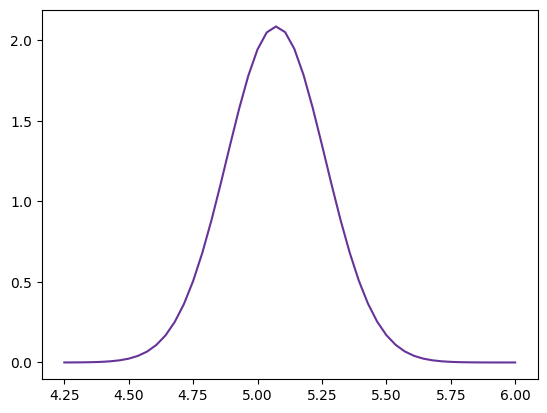

In [18]:
sigma_grid = np.linspace(4.25, 6)
posterior_quadratic_approx = norm.pdf(sigma_grid, mean_q['sigma'], IFisher_inverse[2][2]**0.5)
plt.plot(sigma_grid, posterior_quadratic_approx, color='rebeccapurple')

### Regression for all population

<AxesSubplot:xlabel='weight', ylabel='height'>

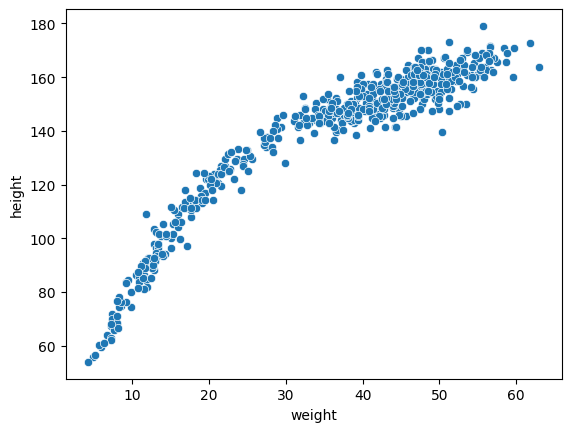

In [19]:
sns.scatterplot(data=dat, x='weight', y='height')

In [20]:
dat_weight_s = (dat['weight']-dat['weight'].mean())/dat['weight'].std()

In [21]:
with pm.Model() as normal_approximation:
    alpha    = pm.Normal('alpha', mu=170, sd=10)
    beta     = pm.Lognormal('beta', mu=0, sigma=1)
    sigma    = pm.Uniform('sigma', lower=0, upper=50)
    height   = pm.Normal('height',
                         mu=alpha + beta * dat_weight_s,
                         sd=sigma, observed=dat['height'])
    mean_q = pm.find_MAP()
    IFisher  = pm.find_hessian(mean_q, vars=[alpha, beta, sigma])

IFisher_inverse = np.linalg.inv(IFisher)

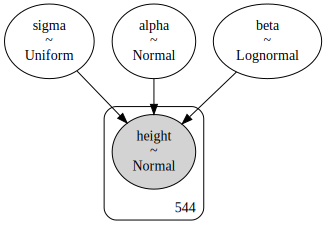

In [22]:
pm.model_to_graphviz(normal_approximation)

### Estimating confidence intervals

In [23]:
x_min      = dat['weight'].min()
x_max      = dat['weight'].max()
weight_seq = np.linspace(x_min, x_max)

In [24]:
posterior_sample = multivariate_normal.rvs(
    size=10**4,
    mean=np.array([mean_q['alpha'], mean_q['beta'], mean_q['sigma']]),
    cov=IFisher_inverse
    )

posterior_sample = pd.DataFrame(posterior_sample, columns=['alpha', 'beta', 'sigma'])

In [25]:
ConfidenceIntervals = pd.DataFrame(
    np.quantile(posterior_sample['alpha']+posterior_sample['beta']*(x_min-dat['weight'].mean())/dat['weight'].std(), [0.025, 0.975]).reshape(1,2),
    columns=['LCI', 'UCI'])

In [26]:
for i in range(1, len(weight_seq)):
    ConfidenceIntervals = pd.concat(
        [ConfidenceIntervals,
         pd.DataFrame(
             np.quantile(posterior_sample['alpha']+posterior_sample['beta']*(weight_seq[i]-dat['weight'].mean())/dat['weight'].std(),
                         [0.025, 0.975]).reshape(1,2),
             columns=['LCI', 'UCI'])
          ])

In [27]:
ConfidenceIntervals['weight'] = weight_seq

### Estimating prediction intervals

In [28]:
height_samp = norm.rvs(size=10**4,
             loc=posterior_sample['alpha']+posterior_sample['beta']*(x_min-dat['weight'].mean())/dat['weight'].std(),
             scale=posterior_sample['sigma'])

PredictionIntervals = pd.DataFrame(np.quantile(height_samp, [0.025, 0.975]).reshape(1,2), columns=['LPI', 'UPI'])

In [29]:
for i in range(1, len(weight_seq)):
    height_samp = norm.rvs(size=10**4,
             loc=posterior_sample['alpha']+posterior_sample['beta']*(weight_seq[i]-dat['weight'].mean())/dat['weight'].std(),
             scale=posterior_sample['sigma'])
    
    PredictionIntervals = pd.concat([PredictionIntervals,
                                     pd.DataFrame(np.quantile(height_samp, [0.025, 0.975]).reshape(1,2), columns=['LPI', 'UPI'])])

In [30]:
PredictionIntervals['weight'] = weight_seq

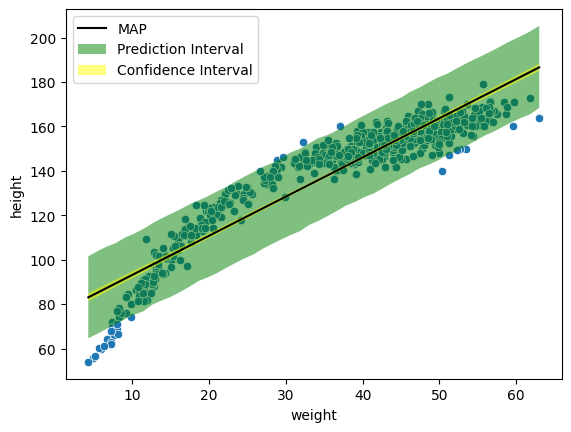

In [31]:
sns.scatterplot(data=dat, x='weight', y='height')

plt.plot([x_min, x_max],
         [mean_q['alpha']+mean_q['beta']*(x_min-dat['weight'].mean())/dat['weight'].std(),
          mean_q['alpha']+mean_q['beta']*(x_max-dat['weight'].mean())/dat['weight'].std()], color='k', label='MAP')

plt.fill_between(PredictionIntervals['weight'], PredictionIntervals['LPI'], PredictionIntervals['UPI'],
                 facecolor='green', alpha=0.5, label='Prediction Interval')

plt.fill_between(ConfidenceIntervals['weight'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'],
                 facecolor='yellow', alpha=0.5, label='Confidence Interval')
plt.legend()

### Regression for all population considering a quadratic polynomial

In [32]:
with pm.Model() as normal_approximation:
    alpha    = pm.Normal('alpha', mu=170, sd=10)
    beta1    = pm.Lognormal('beta1', mu=0, sigma=1)
    beta2    = pm.Normal('beta2', mu=0, sd=1)
    sigma    = pm.Uniform('sigma', lower=0, upper=50)
    height   = pm.Normal('height',
                         mu=alpha + beta1*dat_weight_s + beta2*dat_weight_s**2,
                         sd=sigma, observed=dat['height'])
    mean_q = pm.find_MAP()
    IFisher  = pm.find_hessian(mean_q, vars=[alpha, beta1, beta2, sigma])

IFisher_inverse = np.linalg.inv(IFisher)

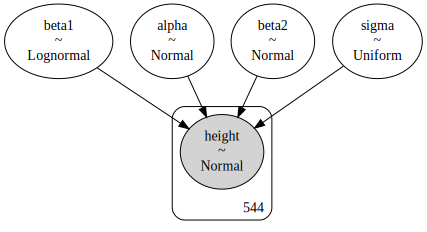

In [33]:
pm.model_to_graphviz(normal_approximation)

### Estimating regression function (MAP)

In [34]:
regression_map = []

for i in range(len(weight_seq)):
    regression_map.append(mean_q['alpha'] + \
                         mean_q['beta1']*(weight_seq[i]-dat['weight'].mean())/dat['weight'].std() + \
                         mean_q['beta2']*((weight_seq[i]-dat['weight'].mean())/dat['weight'].std())**2)

RegressionMAP = pd.DataFrame(regression_map, columns=['regression'])
RegressionMAP['weight'] = weight_seq

### Estimating confidence intervals

In [35]:
posterior_sample = multivariate_normal.rvs(
    size=10**4,
    mean=np.array([mean_q['alpha'], mean_q['beta1'], mean_q['beta2'], mean_q['sigma']]),
    cov=IFisher_inverse
    )

posterior_sample = pd.DataFrame(posterior_sample, columns=['alpha', 'beta1', 'beta2', 'sigma'])

In [36]:
ConfidenceIntervals = pd.DataFrame(
    np.quantile(posterior_sample['alpha'] + \
                posterior_sample['beta1']*(x_min-dat['weight'].mean())/dat['weight'].std() + \
                posterior_sample['beta2']*((x_min-dat['weight'].mean())/dat['weight'].std())**2, [0.025, 0.975]).reshape(1,2),
    columns=['LCI', 'UCI'])

In [37]:
for i in range(1, len(weight_seq)):
    ConfidenceIntervals = pd.concat(
        [ConfidenceIntervals,
         pd.DataFrame(
             np.quantile(posterior_sample['alpha'] + \
                         posterior_sample['beta1']*(weight_seq[i]-dat['weight'].mean())/dat['weight'].std() + \
                         posterior_sample['beta2']*((weight_seq[i]-dat['weight'].mean())/dat['weight'].std())**2,
                         [0.025, 0.975]).reshape(1,2),
             columns=['LCI', 'UCI'])
          ])

In [38]:
ConfidenceIntervals['weight'] = weight_seq

### Estimating prediction intervals

In [39]:
height_samp = norm.rvs(size=10**4,
             loc=posterior_sample['alpha'] + \
                       posterior_sample['beta1']*(x_min-dat['weight'].mean())/dat['weight'].std() + \
                       posterior_sample['beta2']*((x_min-dat['weight'].mean())/dat['weight'].std())**2,
             scale=posterior_sample['sigma'])

PredictionIntervals = pd.DataFrame(np.quantile(height_samp, [0.025, 0.975]).reshape(1,2), columns=['LPI', 'UPI'])

In [40]:
for i in range(1, len(weight_seq)):
    height_samp = norm.rvs(size=10**4,
             loc=posterior_sample['alpha'] + \
                           posterior_sample['beta1']*(weight_seq[i]-dat['weight'].mean())/dat['weight'].std() + \
                           posterior_sample['beta2']*((weight_seq[i]-dat['weight'].mean())/dat['weight'].std())**2,
             scale=posterior_sample['sigma'])
    
    PredictionIntervals = pd.concat([PredictionIntervals,
                                     pd.DataFrame(np.quantile(height_samp, [0.025, 0.975]).reshape(1,2), columns=['LPI', 'UPI'])])

In [41]:
PredictionIntervals['weight'] = weight_seq

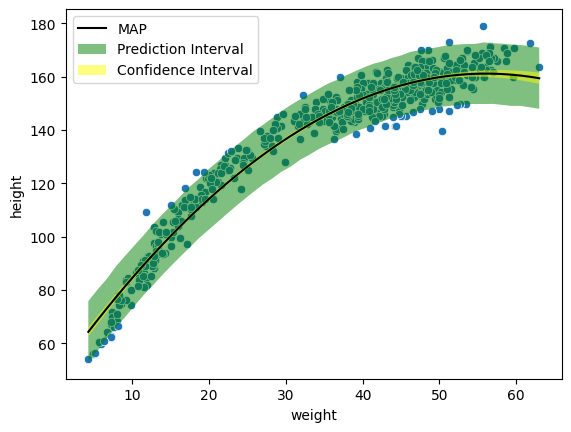

In [42]:
sns.scatterplot(data=dat, x='weight', y='height')

plt.plot(RegressionMAP['weight'], RegressionMAP['regression'], color='k', label='MAP')

plt.fill_between(PredictionIntervals['weight'], PredictionIntervals['LPI'], PredictionIntervals['UPI'],
                 facecolor='green', alpha=0.5, label='Prediction Interval')

plt.fill_between(ConfidenceIntervals['weight'], ConfidenceIntervals['LCI'], ConfidenceIntervals['UCI'],
                 facecolor='yellow', alpha=0.5, label='Confidence Interval')
plt.legend()